### Optional - Install onetime

In [1]:
!pip install xarray-spatial

In [2]:
!pip install richdem

In [3]:
!pip install focal_stats

## Deriving attributes for Wetlands

### Using DEM

Digital Elevation Models (DEMs) provide information on bare ground topography, that is, elevation irrespective of land cover such as buildings/trees. DEMs are often derived from Light Detection and Ranging (LiDAR) data sources. DEMs are used in several applications such as understanding how climatic variables change with topography, and can be used to estimate lapse rate.

Important details:

There are four DEM products available from the Open Data Cube, but we are using only the below two. The Copernicus products come from the European Space Agency (ESA) and the Shuttle Radar Topography Mission (SRTM) products are from the United States Geological Survey (USGS):

- Copernicus DEM 30 m: dem_cop_30, elevation data at 30 m resolution
- DEM SRTM Derivatives: dem_srtm_deriv, derivatives of the 1-arc second DEM which include:

In this notebook we will load the Copernicus 30 m DEM and the DEM derivatives, and use it to train a Random Forest model to detect Wetlands.

Tutorial includes:

Inspecting the DEM product available in the datacube
Using the dc.load() function to load in DEM data
Plotting DEM and its derivatives
An example Random Forest Regression analysis which estimates Wetland probability using the derived parameters

In [2]:
%matplotlib inline

import datacube
from datacube.utils import geometry
import numpy as np
import xarray as xr
import rioxarray
import geojson
import json
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from deafrica_tools.load_era5 import load_era5
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb, display_map
from deafrica_tools.bandindices import calculate_indices
from odc.algo import xr_reproject

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [3]:
import datashader as dso
from datashader.transfer_functions import shade
from datashader.transfer_functions import stack
from datashader.transfer_functions import dynspread
from datashader.transfer_functions import set_background
from datashader.colors import Elevation
from xrspatial import hillshade
from xrspatial import convolution
from xrspatial import focal
import xrspatial

In [4]:
print(datacube.__version__)

1.8.8


In [5]:
dc = datacube.Datacube(app="DEM")

### List availiable products

In [6]:
product_name = ['dem_cop_30', 'dem_srtm_deriv'] 
resolution=(-30, 30) 
measurements='elevation'
dc_measurements = dc.list_measurements()
dc_measurements.loc[product_name].drop('flags_definition', axis=1)

name    dtype units   nodata aliases
product        measurement                                           
dem_cop_30     elevation    elevation  float32     1      NaN     NaN
dem_srtm_deriv mrvbf            mrvbf    int16     1 -32768.0     NaN
               mrrtf            mrrtf    int16     1 -32768.0     NaN
               slope            slope  float32     1  -9999.0     NaN

In [7]:
import geopandas as gpd
gdf = gpd.read_file('SA-Study-Area.geojson')

In [8]:
 # add geom to dc query dict
if isinstance(gdf, datacube.utils.geometry._base.Geometry):
    gdf = gpd.GeoDataFrame({'col1':['name'],'geometry':gdf.geom}, crs=gdf.crs)
geom = geometry.Geometry(geom=gdf.iloc[0].geometry, crs=gdf.crs)

### Plot the area of study

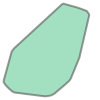

In [9]:
geom

In [10]:
gdf.bounds

,minx,miny,maxx,maxy
0,31.171774,-28.851549,32.737083,-27.156986


In [11]:
measurements='elevation'
#set up daatcube query object
query = {
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements,
    "geopolygon": geom
}

#load the dem 30 m product
ds = dc.load(product="dem_cop_30", **query).squeeze()
print(ds)

<xarray.Dataset>
Dimensions:      (y: 6382, x: 5036)
Coordinates:
    time         datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 -3.339e+06 -3.339e+06 ... -3.531e+06 -3.531e+06
  * x            (x) float64 3.008e+06 3.008e+06 ... 3.159e+06 3.159e+06
    spatial_ref  int32 6933
Data variables:
    elevation    (y, x) float32 1.021e+03 1.022e+03 1.023e+03 ... 0.0 0.0 0.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [12]:
# note how one time slice was selected on export to make the dataset 2D
# note how one time slice was selected on export to make the dataset 2D
ds.elevation.rio.to_raster("sa_dem30m.tif")

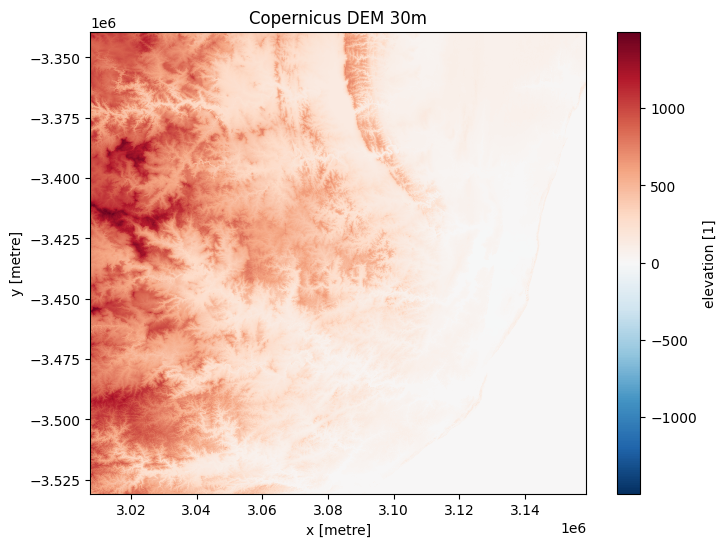

In [13]:
ds.elevation.plot(figsize=(8,6))
plt.title('Copernicus DEM 30m');

In [14]:
# We just need to change the measurements parameter, lats, lon, crs etc. can remain the same. 
measurements=['mrvbf', 'mrrtf', 'slope'] 

query = {
    'resolution':resolution,
    'output_crs': 'epsg:6933',
    'measurements':measurements,
    "geopolygon": geom
}

ds_deriv = dc.load(product="dem_srtm_deriv", **query).squeeze()
print(ds_deriv)

<xarray.Dataset>
Dimensions:      (y: 6382, x: 5036)
Coordinates:
    time         datetime64[ns] 2000-01-01T12:00:00
  * y            (y) float64 -3.339e+06 -3.339e+06 ... -3.531e+06 -3.531e+06
  * x            (x) float64 3.008e+06 3.008e+06 ... 3.159e+06 3.159e+06
    spatial_ref  int32 6933
Data variables:
    mrvbf        (y, x) int16 1 1 1 0 0 0 0 1 1 1 2 2 ... 7 7 7 7 7 7 7 7 7 7 7
    mrrtf        (y, x) int16 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    slope        (y, x) float32 10.83 11.26 10.96 11.79 ... 0.0 0.0 0.0 0.0
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [15]:
gdf.bounds

,minx,miny,maxx,maxy
0,31.171774,-28.851549,32.737083,-27.156986


### Actual Study Area

In [16]:
display_map(x=(gdf.bounds.minx,gdf.bounds.maxx), y=(gdf.bounds.miny,gdf.bounds.maxy))

Slope (percent); this is the rate of elevation change, so mathematically speaking it is the first/primary derivative of elevation.
Multi-resolution Valley Bottom Flatness (MrVBF); this identifies valley bottoms (areas of deposition). Zero values indicate erosional terrain and values ≥1 and indicate progressively larger areas of deposition.
Multi-resolution Ridge Top Flatness (MrRTF); complementary to MrVBF, zero values indicate areas that are steep or low, and values ≥1 indicate progressively larger areas of high flat land.


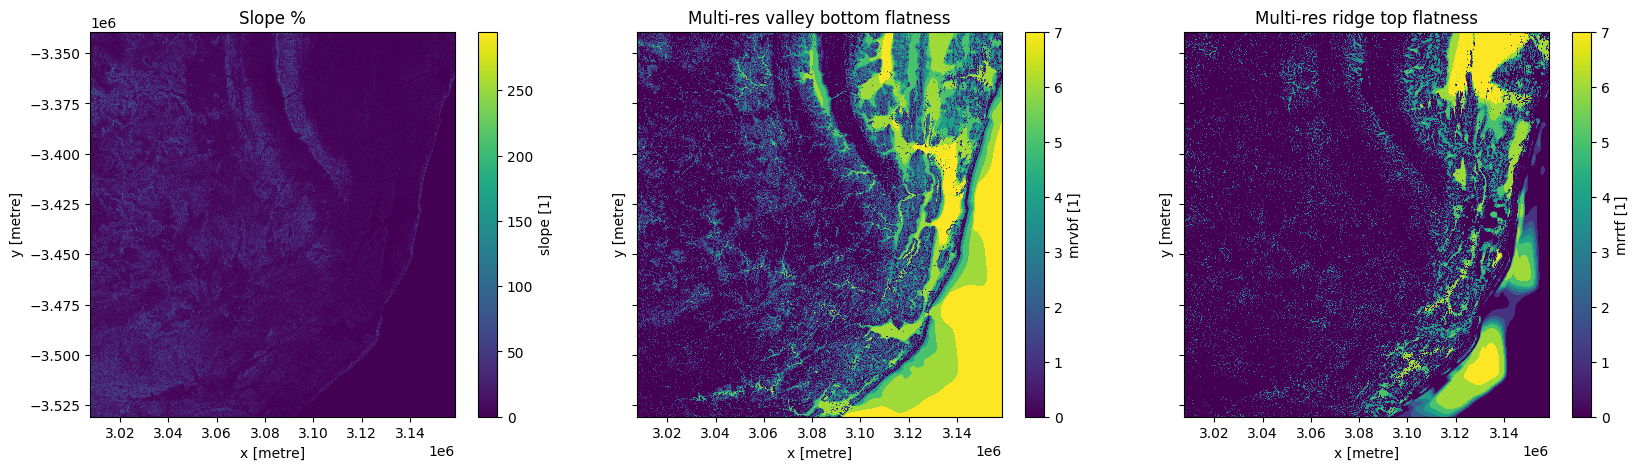

In [17]:
fig,ax = plt.subplots(1,3, figsize=(20,5), sharey=True)
ds_deriv.slope.plot(ax=ax[0])
ds_deriv.mrvbf.plot(ax=ax[1])
ds_deriv.mrrtf.plot(ax=ax[2])

ax[0].set_title('Slope %')
ax[1].set_title('Multi-res valley bottom flatness')
ax[2].set_title('Multi-res ridge top flatness');

In [18]:
import richdem as rd
ma = rd.rdarray(ds.elevation,no_data=-9999)

Slope

Slope is the inclination of a surface. In geography, slope is amount of change in elevation of a terrain regarding its surroundings. Horn (1981) calculates the slope of a focal cell by using a central difference estimation of a surface fitted to the focal cell and its neighbours. The slope chosen is the maximum of this surface and can be returned in several formats.

Datashader's slope function returns slope in degrees. Below we highlight areas at risk for avalanche by looking at slopes around 38 degrees.

In [19]:
ma_slope=rd.TerrainAttribute(ma,attrib='slope_degrees')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.54169======================== ] (99% - 0.0s - 1 threads)


In [20]:
#Save the Slope
import rasterio as rio
import numpy
with rio.open("sa_dem30m.tif") as f:
    profile = f.profile
    profile.update(dtype=numpy.float64, count=1, compress='lzw')
    with rio.open('./sa_dem30m_ma_slope.tif', 'w', **profile) as dst:
        dst.write(ma_slope.astype(numpy.float64), 1)
           

Aspect

Horn (1981) calculates aspect as the direction of the maximum slope of the focal cell. The value returned is in Degrees. Aspect) is the orientation of slope, measured clockwise in degrees from 0 to 360, where 0 is north-facing, 90 is east-facing, 180 is south-facing, and 270 is west-facing.

Below, we look to find slopes that face close to North.

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Aspect attribute calculation
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 1.90864======================== ] (99% - 0.0s - 1 threads)


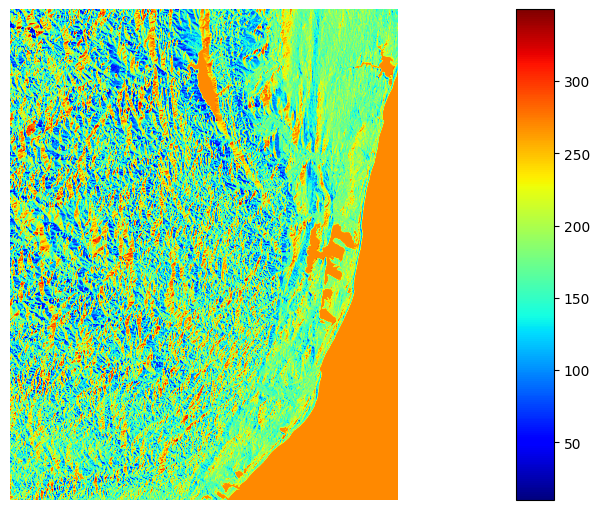

In [21]:
ma_aspect = rd.TerrainAttribute(ma, attrib='aspect')
rd.rdShow(ma_aspect, axes=False, cmap='jet', figsize=(8, 5.5))
plt.show()

In [22]:
#Save the Aspect
import rasterio as rio
import numpy
with rio.open("sa_dem30m.tif") as f:
    profile = f.profile
    profile.update(dtype=numpy.float64, count=1, compress='lzw')
    with rio.open('./sa_dem30m_ma_aspect.tif', 'w', **profile) as dst:
        dst.write(ma_aspect.astype(numpy.float64), 1)
           

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

t Wall-time = 0.385258======================= ] (99% - 0.0s - 1 threads)


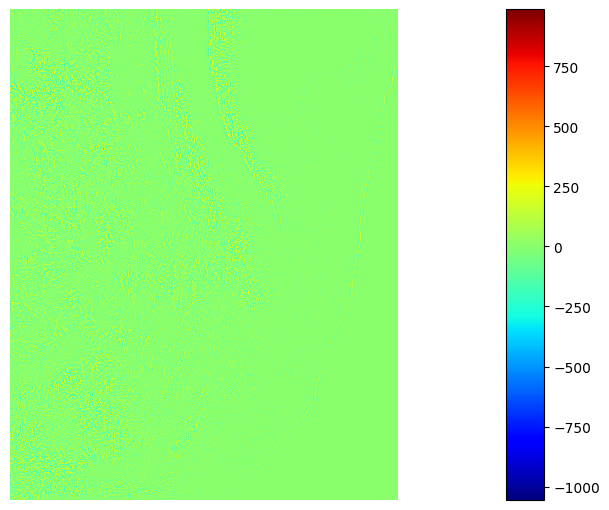

{'vmin': -1055.4969116210937, 'vmax': 987.4252160644535}

In [23]:
ma_curvature = rd.TerrainAttribute(ma, attrib='curvature')
rd.rdShow(ma_curvature, axes=False, cmap='jet', figsize=(8,5.5))

In [24]:
#Save the curvature
import rasterio as rio
import numpy
with rio.open("sa_dem30m.tif") as f:
    profile = f.profile
    profile.update(dtype=numpy.float64, count=1, compress='lzw')
    with rio.open('./sa_dem30m_curvature.tif', 'w', **profile) as dst:
        dst.write(ma_curvature.astype(numpy.float64), 1)
                    


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Profile curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

t Wall-time = 0.71345======================== ] (99% - 0.0s - 1 threads)


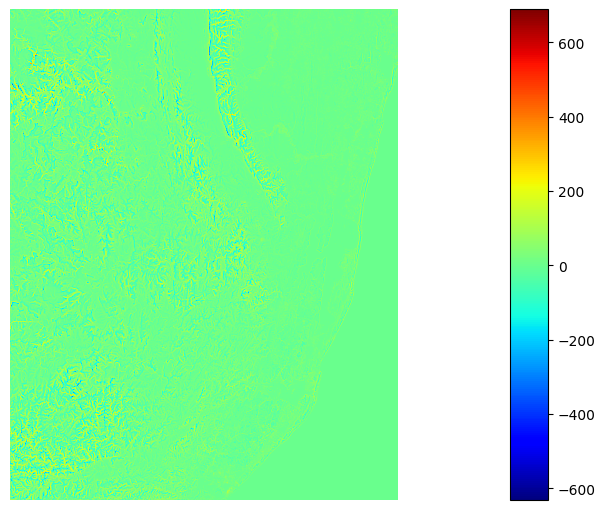

{'vmin': -631.01546875, 'vmax': 688.9490869140627}

In [25]:
ma_profile_curvature = rd.TerrainAttribute(ma, attrib='profile_curvature')
rd.rdShow(ma_profile_curvature, axes=False, cmap='jet', figsize=(8,5.5))

In [26]:
#Save the profile_curvature
import rasterio as rio
import numpy
with rio.open("sa_dem30m.tif") as f:
    profile = f.profile
    profile.update(dtype=numpy.float64, count=1, compress='lzw')
    with rio.open('./sa_dem30m_profile_curvature.tif', 'w', **profile) as dst:
        dst.write(ma_profile_curvature.astype(numpy.float64), 1)
                    


Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A Planform curvature attribute calculation
C Zevenbergen, L.W., Thorne, C.R., 1987. Quantitative analysis of land surface topography. Earth surface processes and landforms 12, 47–56.

t Wall-time = 0.709379======================= ] (99% - 0.0s - 1 threads)


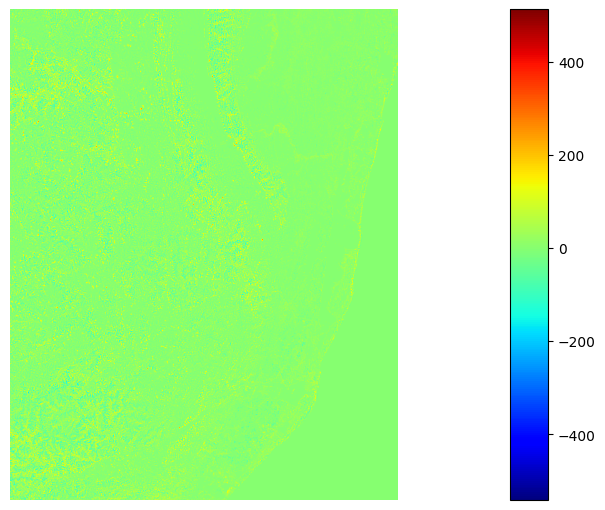

{'vmin': -541.0590490722656, 'vmax': 512.7222802734377}

In [27]:
planform_curvature = rd.TerrainAttribute(ma, attrib='planform_curvature')
rd.rdShow(planform_curvature, axes=False, cmap='jet', figsize=(8,5.5))

In [28]:
#Save the planform_curvature
import rasterio as rio
import numpy
with rio.open("sa_dem30m.tif") as f:
    profile = f.profile
    profile.update(dtype=numpy.float64, count=1, compress='lzw')
    with rio.open('./sa_dem30m_planform_curvature.tif', 'w', **profile) as dst:
        dst.write(planform_curvature.astype(numpy.float64), 1)
                    


What is the value range for topographic wetness index?
Typically the raw TWI indicators range from -3 to 30. 
Cells with a lower index value represent areas with steepest slope and tend to be ridges or crests present on the landscape. 
Higher cell values represent areas with increased accumulated runoff potential.

In [29]:
#Get flow accumulation with no explicit weighting. The default will be 1.
accum_d8 = rd.FlowAccumulation(ma, method='D8')

Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)
Warning! No geotransform defined. Choosing a standard one! (Top left cell's top let corner at <0,0>; cells are 1x1.)



A O'Callaghan (1984)/Marks (1984) D8/D4 Flow Accumulation
C O'Callaghan, J.F., Mark, D.M., 1984. The Extraction of Drainage Networks from Digital Elevation Data. Computer vision, graphics, and image processing 28, 323--344.

c topology = D8
[================================================= ] (99% - 0.0s - 1 threads)
A Generic Flow Accumulation Algorithm
p Creating dependencies array...

d Source cells found = 13749690
p Calculating flow accumulation...
t Wall-time       = 2.64756 s================ ] (99% - 0.0s - 1 threads)


What does topographic wetness index tell you?
Topographic Wetness Index is used to quantify topographic controls on hydrological processes. Topographic Wetness Index (TWI) can also be used to characterize biological processes including forest site quality, vegetation patterns, and annual net primary production (Beven & Kirkby, 1979; Sorenson, et al., 2006).

In [30]:
import math
# 2Pi radians = 360 degrees
	# Pi radians = 180 degrees
	# conversion: Pi radians/180 degress
slope_radians = ma_slope * math.pi/180.0

https://blogs.ubc.ca/tdeenik/2021/03/08/topographic-wetness-index-twi/

What is TWI?

TWI is a commonly used index in hydrological analysis for describing the tendency of an area to accumulate water. 
It basically tells us how likely an area is to be wet. Important for wetland identification as you can imagine. 
It is based on slope and contributing area. 
Areas with higher topographic wetness index values are likely to be wetter relative to areas with lower values. 
The calculation is as follows, where SCA is the specific catchment area and φ is the slope angle. 

TWI=ln(SCA/tanφ)

Slope is easy enough to calculate from the DEM and a simple function can be run to do so (I ran all of my calculations through WhiteBox-GAT, more on that below). The calculation of SCA is a bit more complicated. Specific Catchment Area (SCA) is defined as the contributing area per unit width of contour  (i.e. the catchment area divided by the flow width). The contributing area (aka basin) represents the size of the upslope area draining into a cell. To calculate the contributing area, a flow routing algorithm is used. This quantifies how the water flows on the land surface and establishes the direction of the flow for every cell. There are a variety of algorithms that have been created for this purpose. They fall within two main categories: single flow direction and multi flow direction.

Deterministic eight-node (D8) is a common single flow direction algorithm by O’Callaghan and Mark, 1984 (see also Garbrecht and Martz 1997). It determines the flow direction based on the steepest descent toward one of the eight neighboring cells. The problem with this model is that it tends to concentrate along distinct, often artificially straight lines. Another problem occurs when the steepest gradient falls between two of the eight cardinal and diagonal directions (López-Vicente et al. 2014). 

In [31]:
#TWI - Every cell calculate the upslope contributing area - stream 
twi = np.log(accum_d8 / (np.tan(slope_radians)+.01))



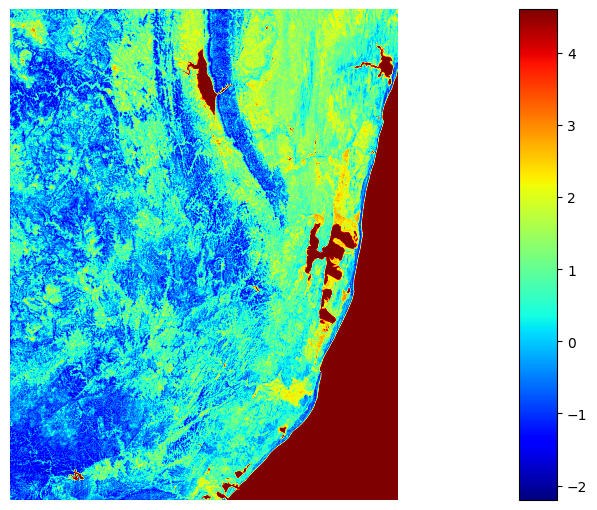

{'vmin': -2.2001109944764146, 'vmax': 4.605170208339834}

In [32]:
rd.rdShow(twi, axes=False, cmap='jet', figsize=(8,5.5))

In [33]:
#Save the TWI
import rasterio as rio
import numpy
with rio.open("sa_dem30m.tif") as f:
    profile = f.profile
    profile.update(dtype=numpy.float64, count=1, compress='lzw')
    with rio.open('./sa_dem30m_twi.tif', 'w', **profile) as dst:
        dst.write(twi.astype(numpy.float64), 1)
                    

    

### Plot to verify the TWI

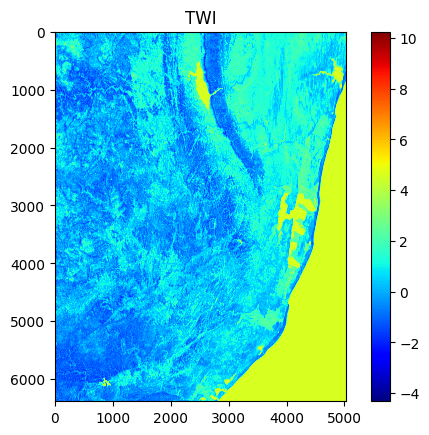

In [34]:
with rio.open("sa_dem30m_twi.tif") as tw:
    atw = tw.read(1)
    
plt.imshow(atw, cmap='jet')
plt.title("TWI")
plt.colorbar()

In [35]:
terrain=ds.elevation

In [36]:
cellsize_x, cellsize_y = convolution.calc_cellsize(terrain)

# Use an annulus kernel with a ring at a distance from 25-30 cells away from focal point
outer_radius = str(cellsize_x * 30) + "m"
inner_radius = str(cellsize_x * 25) + "m"
kernel = convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

tpi = terrain - focal.apply(terrain, kernel)

tpi_terrain = hillshade(terrain - focal.apply(terrain, kernel))
tpi_terrain_shaded = shade(
    tpi_terrain, cmap=["white", "black"], alpha=255, how="linear"
)


In [42]:
convolution.annulus_kernel(cellsize_x, cellsize_y, outer_radius, inner_radius)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
cellsize_x, cellsize_y

(30.0, 30.0)

In [43]:
outer_radius

'900.0m'

In [44]:
inner_radius

'750.0m'

In [50]:
outer_radius_test = str(cellsize_x * 2) + "m"

In [51]:
(convolution.circle_kernel(cellsize_x, cellsize_y, outer_radius_test))

array([[0., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 0.]])

### Save the TPI

In [37]:
tpi.rio.to_raster("sa_dem30m_tpi.tif")

Shaded relief, or hillshading, is a technique where a lighting effect is added to a map based on elevation variations within the landscape. It provides a clearer picture of the topography by mimicing the sun's effects (illumination, shading and shadows) on hills and canyons.

In [38]:
tpi_terrain.rio.to_raster("sa_dem30m_hillshade.tif")

### Curvature
Curvature is the second derivative of a surface’s elevation, or the slope-of-the-slope; in other words, how fast the slope is increasing or decreasing as we move along a surface. - A positive curvature means the surface is curving up (upwardly convex) at that cell. - A negative curvature means the surface is curving down (downwardly convex) at that cell. - A curvature of 0 means the surface is striaght and constant in whatever angle it’s sloped towards.

Reasonably expected values in the curvature raster for a hilly area (moderate relief) would be between -0.5 and 0.5, while for steep, rugged mountains (extreme relief) these can range as far as -4 and 4. For certain raster surfaces it is possible to go even larger than that.

In [1]:
#curvature
from xrspatial import curvature
curv = curvature(terrain)

/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


NameError: name 'terrain' is not defined

In [54]:
curv_hi, curv_low = curv.copy(), curv.copy()
curv_hi.data = np.where(np.logical_and(curv_hi.data > 1, curv_hi.data < 4), 1, np.nan)
curv_low.data = np.where(
    np.logical_and(curv_low.data > 0.5, curv_low.data < 1), 1, np.nan
)

Hillshade

Hillshade is a technique used to visualize terrain as shaded relief, illuminating it with a hypothetical light source. The illumination value for each cell is determined by its orientation to the light source, which is based on slope and aspect.

NameError: name 'illuminated' is not defined

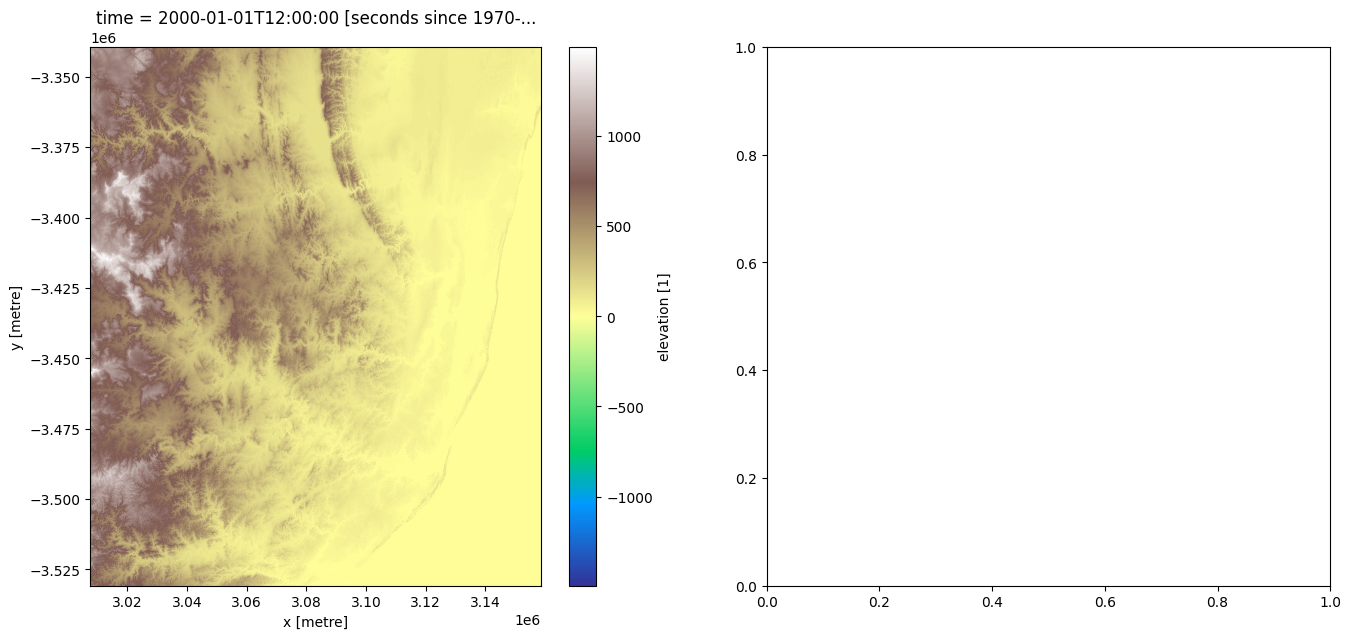

In [55]:

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 7))
terrain.plot.imshow(ax=ax1, cmap='terrain')
illuminated.plot.imshow(ax=ax2, cmap='jet')
plt.tight_layout()

### Build Random Forest Model

In [ ]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score, f1_score